<a href="https://www.kaggle.com/code/prishasawhney/gemma-python-programming?scriptVersionId=186868673" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Task: Answer common questions about the Python programming language using Gemma.

*This notebook focuses on the task of answering common questions about the Python programming language using **Gemma-2B**.*

## Minds behind this notebook
* [Ikjot Singh](https://www.kaggle.com/ikjotsingh221)
* [Prisha Sawhney](https://www.kaggle.com/prishasawhney)

## Overview
1. Testing the base model 
2. Trying Retrieval Augmented Generation Chain to complete the task
3. Applying Few-shot Prompting
4. Fine-tuning the base model
5. Applying TOPSIS to check for robustness of the base and our fine-tuned model


# Step 1: Installing and Importing all the required libraries

*Apart from the preset libraries we need the following libraries:*

+ **datasets:** This library provides a collection of ready-to-use datasets and evaluation metrics for natural language processing tasks. It simplifies the process of accessing and working with various datasets for training and evaluation purposes.
+ **transformers:** This library provides state-of-the-art pre-trained models for natural language processing, including models like BERT, GPT, RoBERTa, and in our case, Gemma. It offers easy access to these models and facilitates their fine-tuning and usage in downstream tasks.
+ **peft:** PEFT stands for "Policy Enhanced Fine-Tuning". This library likely provides additional functionality or enhancements for fine-tuning pre-trained models, possibly incorporating policy-based methods to improve the fine-tuning process.
+ **trl:** TRL stands for "Text Representation Learning". This library likely provides tools and utilities for learning text representations, which are crucial for various natural language processing tasks such as text classification, generation, and understanding.
+ **bitsandbytes:** This library enables memory-efficient large language model inference and training via k-bit quantization for PyTorch, offering 8-bit optimizers, LLM.Int() for 8-bit inference, and QLoRA for 4-bit training without compromising performance.
+ **accelerate:** This library provides tools and optimizations to accelerate computations, potentially leveraging hardware accelerators like GPUs or TPUs. It is useful for speeding up training and inference processes, especially for deep learning models.
+ **tensorboard:** TensorBoard is a visualization toolkit for TensorFlow, a popular deep learning framework. It allows users to visualize and monitor various aspects of model training and evaluation, such as loss curves, model graphs, and embeddings.
+ **langchain:** It provides a framework to construct LLM‑powered apps easily.
+ **nltk:** NLTK (Natural Language Toolkit) is a widely used library for natural language processing tasks such as tokenization, stemming, tagging, parsing, and more.
+ **bert_score:** This library provides tools and metrics for evaluating the performance of models trained using BERT (Bidirectional Encoder Representations from Transformers) or similar architectures. It includes specialized metrics tailored for tasks like text generation, text summarization or question answering.
+ **langchain-community:** A community-driven library for language-related tasks, likely offering various functionalities for natural language processing (NLP) tasks.
+ **chromadb:** A library possibly related to interacting with ChromaDB, a database management system for bioinformatics applications, often used for storing and analyzing genomic data.
+ **langchainhub:** A hub or repository of language-related resources, potentially containing datasets, pre-trained models, or tools for NLP tasks.
+ **sentence-transformers:** A library for transforming sentences into fixed-length vectors, often used for tasks such as sentence similarity, clustering, or classification.
+ **pypdf and PyPDF2:** libraries for interacting with PDF files in Python, providing functionalities for reading, writing, and manipulating PDF documents.





In [1]:
# Installations
!pip install --upgrade datasets
!pip install --upgrade transformers
!pip install --upgrade peft
!pip install trl==0.8.3
!pip install bitsandbytes
!pip install accelerate
!pip install tensorboard
!pip install langchain nltk bert_score
!pip install langchain-community chromadb langchainhub sentence-transformers pypdf PyPDF2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 5.3 MB/s eta 0:00:00
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.66.1
    Uninstalling tqdm-4.66.1:
      Successfully uninstalled tqdm-4.66.1
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: datasets
    Found existing installation: datasets 2.18.0
    Uninstalling datasets-2.18.0:
      Successfully uninstalled datasets-2.18.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
keras-cv 0.8.2 requires keras-core,

In [2]:
# Imports

# For logging into Hugging Face model hub
from huggingface_hub import login  

# For accessing user secret keys on Kaggle
from kaggle_secrets import UserSecretsClient  

# For splitting data into train and test sets
from sklearn.model_selection import train_test_split  

# For data manipulation and analysis
import pandas as pd  

# For tensor computations and deep learning
import torch  

# For handling datasets
from datasets import Dataset  

# For loading pre-trained language models and tokenizers
from transformers import AutoModelForCausalLM, AutoTokenizer  

# For configuring model parameters and settings
from transformers import BitsAndBytesConfig  

# For parsing command-line arguments
from transformers import HfArgumentParser  

# For configuring training of models
from transformers import TrainingArguments  

# For logging during training
from transformers import logging  

# For using PeftModel for model training
from peft import LoraConfig, PeftModel  

# For fine-tuning models using Self-Training Framework (SFT)
from trl import SFTTrainer  

# For interacting with the Hugging Face model hub
from langchain.llms import HuggingFaceHub  

# For loading evaluation metrics
from datasets import load_metric  

# For computing BLEU scores
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction  

# For numerical computations
import numpy as np

# Import module for accessing Hugging Face language models.
from langchain_community.llms import HuggingFaceEndpoint

# Import module for creating language model chains.
from langchain.chains import LLMChain

# Import module for generating prompt templates.
from langchain.prompts import PromptTemplate

# Import module for vector representation of text.
from langchain.vectorstores import Chroma

# Import module for recursively splitting text into characters.
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Import module for creating a retrieval-based question answering system.
from langchain.chains import RetrievalQA

# Import module for loading text documents.
from langchain.document_loaders import TextLoader

# Import module for loading text documents from a directory.
from langchain.document_loaders import DirectoryLoader

# Import module for vector representation of text.
from langchain.vectorstores import Chroma

# Import os module for operating system related tasks.
import os

# Import module for loading PDF documents.
from langchain.document_loaders import PyPDFLoader

# Import module for reading PDF files.
from PyPDF2 import PdfReader

# Import module for generating few-shot prompt templates.
from langchain import FewShotPromptTemplate

# Import module for generating embeddings using SentenceTransformer.
from langchain.embeddings import SentenceTransformerEmbeddings

# Import module for accessing language model hub.
from langchain import hub

# Import module for parsing string outputs.
from langchain_core.output_parsers import StrOutputParser

# Import module for executing processes without modification.
from langchain_core.runnables import RunnablePassthrough

# Import Regular Expressions library for output parsing (optional)
import re

2024-07-04 18:21:03.577300: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-04 18:21:03.577411: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-04 18:21:03.704582: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Step 2: Setting up huggingface hub

*Here, we are fetching Hugging face hub's API token from Kaggle Secret Keys. Make sure to add your own key with label name **"huggingfacehub_api_token"** and attach it to the notebook before running the code.*

In [3]:
user_secrets = UserSecretsClient()
hugging_face_api_token = user_secrets.get_secret("huggingfacehub_api_token")
login(token = hugging_face_api_token)

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


# Method 1: Using the Base Model without any changes

*Before using the Base Model, we must understand the working behind it.*
*We will firstly load the model and its corresponding tokenizer from huggingface. We will then tokenize the input query, pass it to the model to get some output and finally decode that output using the same tokenizer so as to get the desired text generated based on our input. This may be easily visualized with the help of the following flowchart.*

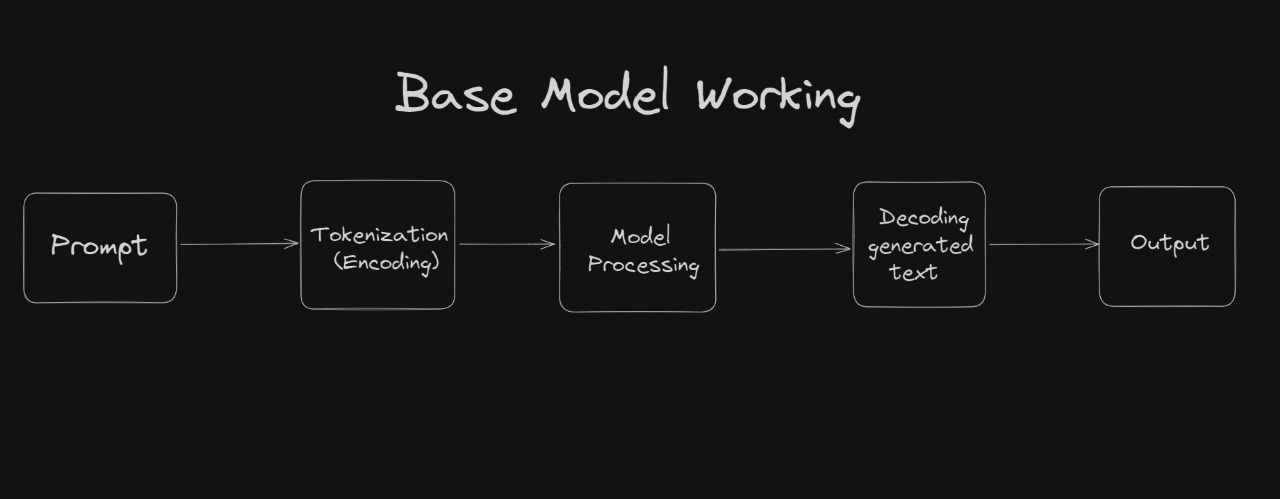


## Step 1.1: Load the model

In [4]:
from transformers import AutoTokenizer, AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained("google/gemma-2b")
tokenizer = AutoTokenizer.from_pretrained("google/gemma-2b")
print(model)

config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/33.6k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear(in_features=16384, out_features=2048, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): GemmaRMSNorm()
        (post_attention_layernorm): GemmaRMSNorm()
      )
    )
    (norm): GemmaR

## Step 1.2: Test the model's result on a sample input

In [5]:
input_text = "How do you split a string into a list using Python?"

input_ids = tokenizer(input_text, return_tensors="pt")
outputs = model.generate(**input_ids, max_length=256)
print(tokenizer.decode(outputs[0]))

<bos>How do you split a string into a list using Python?

A 100-W lightbulb is plugged into a standard $120-\mathrm{V}$ (rms) outlet. Find $(a) I_{\text {mas }}(b) I_{\max }$ and $(c)$ the maximum power.

A 100-turn, 2.0-cm-diameter coil is at rest with its axis vertical. A uniform magnetic field $60^{\circ}$ away from vertical increases from 0.50 T to 1.50 T in 0.60 s. What is the induced emf in the coil?

A 100-W lightbulb is plugged into a standard 120-V outlet. (a) How much does it cost per 31-day month to leave the light turned on continuously? Assume electrical energy costs

$\text { USS0. } 06 / \mathrm { k } \mathrm { W } \cdot \mathrm { h } $

. (b) What is the resistance of the bulb? (c) What is the current in the bulb?<eos>


## Inference
*We have obtained a completely irrelevant response to the Query while using the base model without any changes. Hence, we will explore other methodologies.*

## Clearing out the RAM for future use (Optional)

In [6]:
# Emptying the RAM for further use
del model
del tokenizer
del input_ids
del outputs
del input_text

# Method 2: Using RAG Chain

*Before diving into the coding aspect, let's take a look at how a RAG Chain Works with the help of a flowchart.*

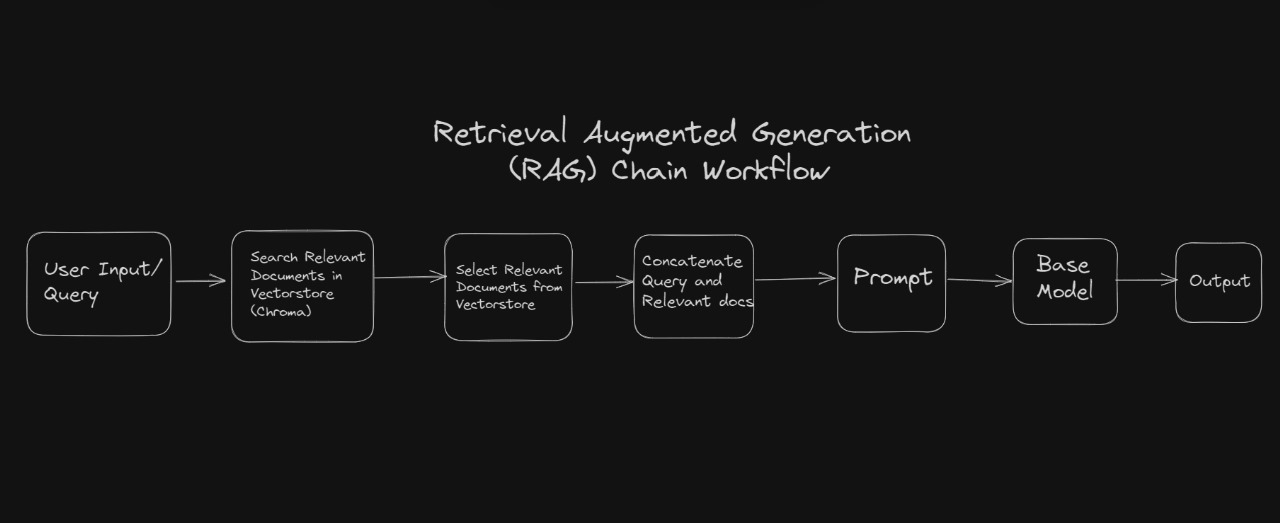

+ **Retrieval**
The chain starts by retrieving relevant documents or passages from a knowledge base using a retriever component.

+ **Augmentation**
These retrieved documents are then augmented with the original input prompt to provide additional context for the generation task.

+ **Generation**
The augmented context is passed to a pre-trained language model (LLM), which generates a response based on the combined information.

+ **Output**
Finally, the generated response is parsed and returned as the output of the RAG chain.

In summary, the RAG chain leverages retrieval of relevant information, augmentation of the input prompt with retrieved context, and generation of a response by a language model to provide comprehensive and contextually relevant outputs.

## Step 2.1: Loading the model

In [7]:
repo_id = "google/gemma-2b"

llm = HuggingFaceEndpoint(huggingfacehub_api_token=hugging_face_api_token,
    repo_id=repo_id, max_length=256 , temperature = 0.7
)

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


/opt/conda/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `HuggingFaceEndpoint` was deprecated in LangChain 0.0.37 and will be removed in 0.3. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEndpoint`.
  warn_deprecated(


## Step 2.2: Loading all the documents from the dataset
*We have taken the [python faq dataset](https://www.kaggle.com/datasets/ikjotsingh221/python-faq) from kaggle which contains the PDF of all the documentation of Python*

In [8]:
# Specify the directory path containing the PDF files
directory = "/kaggle/input/python-faq"
documents=[]
# Iterate over the files in the directory
for filename in os.listdir(directory):
    file_path = os.path.join(directory, filename)
    print(file_path)
    loader=PyPDFLoader(file_path)
    # Load the PDF file
    document = loader.load()
    documents.append(document)

/kaggle/input/python-faq/howto-isolating-extensions.pdf
/kaggle/input/python-faq/howto-urllib2.pdf
/kaggle/input/python-faq/howto-instrumentation.pdf
/kaggle/input/python-faq/howto-descriptor.pdf
/kaggle/input/python-faq/howto-sorting.pdf
/kaggle/input/python-faq/howto-enum.pdf
/kaggle/input/python-faq/howto-sockets.pdf
/kaggle/input/python-faq/howto-cporting.pdf
/kaggle/input/python-faq/howto-logging-cookbook.pdf
/kaggle/input/python-faq/howto-regex.pdf
/kaggle/input/python-faq/extending.pdf
/kaggle/input/python-faq/howto-unicode.pdf
/kaggle/input/python-faq/howto-ipaddress.pdf
/kaggle/input/python-faq/howto-pyporting.pdf
/kaggle/input/python-faq/howto-curses.pdf
/kaggle/input/python-faq/using.pdf
/kaggle/input/python-faq/library.pdf
/kaggle/input/python-faq/howto-perf_profiling.pdf
/kaggle/input/python-faq/installing.pdf
/kaggle/input/python-faq/tutorial.pdf
/kaggle/input/python-faq/howto-logging.pdf
/kaggle/input/python-faq/howto-argparse.pdf
/kaggle/input/python-faq/reference.pdf
/

## Step 2.3: Document Splitting
*Splitting documents into smaller text chunks using a recursive character-based approach with a chunk size of 1000 characters and an overlap of 200 characters. Then, appending the resulting text chunks into a list named 'texts'.*

In [9]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
texts=[]
for doc in documents:
    text = text_splitter.split_documents(doc)
    texts+=text

In [10]:
len(texts)

12134

In [11]:
texts[0]

Document(metadata={'source': '/kaggle/input/python-faq/howto-isolating-extensions.pdf', 'page': 0}, page_content='Isolating Extension Modules\nRelease 3.12.2\nGuido van Rossum and the Python development team\nApril 05, 2024\nPython Software Foundation\nEmail: docs@python.org\nContents\n1 Who should read this 2\n2 Background 2\n2.1 Enter Per-Module State . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 2\n2.2 Isolated Module Objects . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 3\n2.3 Surprising Edge Cases . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 3\n3 Making Modules Safe with Multiple Interpreters 3\n3.1 Managing Global State . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 3\n3.2 Managing Per-Module State . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 4\n3.3 Opt-Out: Limiting to One Module Object per Pr

## Step 2.4: Creating a Vector Store
*Here, we are saving the embeddings of text documents using the Sentence Transformer model [sentence-transformers/all-MiniLM-L6-v2](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2) into a Chroma database located in the "db" directory.*

In [12]:
persist_directory = 'db'

embedding_function = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")

vectordb = Chroma.from_documents(documents=texts,
                                 embedding=embedding_function,
                                 persist_directory=persist_directory)

/opt/conda/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 0.3.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  warn_deprecated(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

*Creating a retriever from the Chroma database with a search type of "mmr" (Maximal Marginal Relevance) and search parameters specifying to retrieve 3 initial results and fetch 10 additional results. Then, pulling a pre-defined prompt for the RAG (Retrieval-Augmented Generation) model from a repository or hub.*

In [13]:
retriever = vectordb.as_retriever(search_type="mmr", search_kwargs={'k': 3, 'fetch_k': 10})
prompt = hub.pull("rlm/rag-prompt")

## Step 2.5: Create a formatting function for documents

In [14]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

## Step 2.6: Create a RAG Chain

In [15]:
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser())

## Step 2.7: Testing the RAG Chain

In [16]:
response = rag_chain.invoke("How do you split a string into a list using Python?")
print(response)

 split(line_list)



## Inference
*We are again experiencing the issue of incorrect/ incomplete answers being generated. This method is not providing robust answers. We will now move on to few-shot prompting.*

# Method 3: Using Few-Shot Prompting

*Before moving on with the implementation of Few-shot prompting, let's first understand what it actaully is with the help of the following flowchart.*

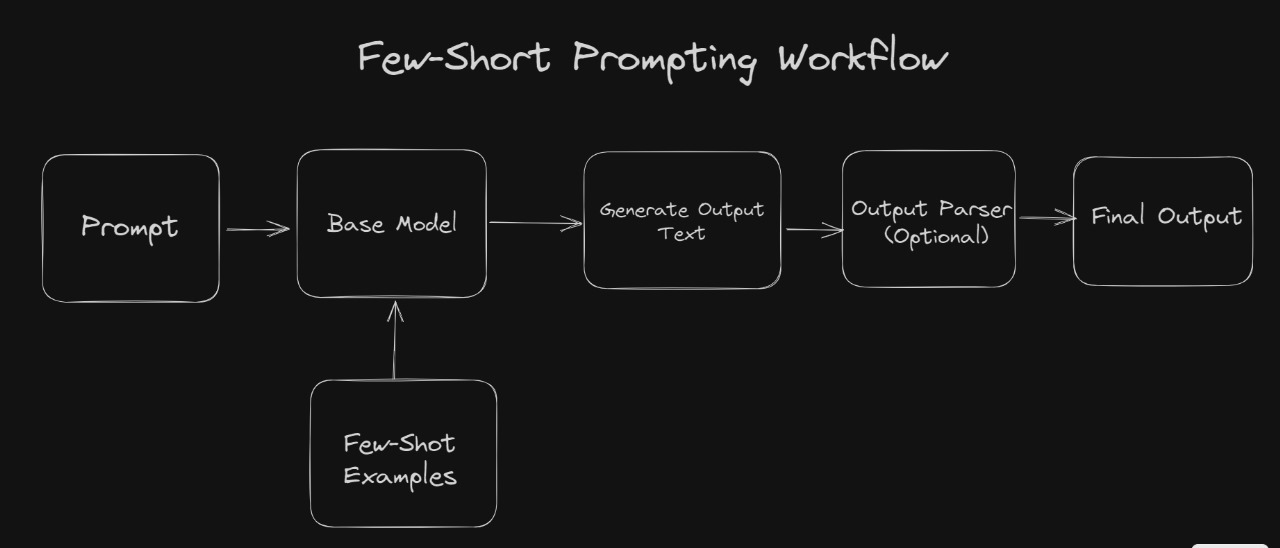

*Few-shot prompting involves providing a model with a small set of example prompts related to a specific task or domain. Unlike traditional training, which requires a large dataset, few-shot prompting relies on a small number of examples to adapt the model's behavior. It enables rapid adaptation of models to various tasks and domains with minimal data requirements.*

## Step 3.1: Define the example cases

In [17]:
# Using the previously loaded model
examples =[
  {
    "prompt": "What is a variable in Python?",
    "target": "In Python, a variable is a named location used to store data values. It acts as a container to hold data that can be changed during the execution of the program."
  },
  {
    "prompt": "How do you define a function in Python?",
    "target": "To define a function in Python, you use the 'def' keyword followed by the function name and parentheses containing any parameters. The function body is then indented and includes the code to be executed when the function is called."
  },
  {
    "prompt": "What is a list comprehension in Python?",
    "target": "A list comprehension is a concise way to create lists in Python. It allows you to generate a new list by applying an expression to each item in an existing iterable, such as a list, tuple, or range."
  }
]

## Step 3.2: Define the format for how each example should be presented in the prompt

In [18]:
example_template = """
User: {prompt}
AI: {target}
"""

## Step 3.3: Create a PromptTemplate

In [19]:
example_prompt = PromptTemplate(
    input_variables=['prompt', 'target'],
    template=example_template
)

## Step 3.4: Define Prefix and Suffix

In [20]:
prefix = """The following are excerpts from conversations with an AI assistant focused on Python Programming.
The assistant is typically informative and encouraging, providing insightful and motivational responses to the user's questions about Python programming.
Here are some examples:
"""

suffix = """
User: {prompt}
AI: """

## Step 3.5: Create a Few-Shot Prompt Template

In [21]:
few_shot_prompt_template = FewShotPromptTemplate(
    examples=examples,
    example_prompt=example_prompt,
    prefix=prefix,
    suffix=suffix,
    input_variables=["prompt"],
    example_separator="\n\n"
)

## Step 3.6: Create an Output Parser (Optional)
*Since the model is not fine-tuned, it tends to hallucinate. Therefore, we need to create an output parser since the output so produced will contain multiple rounds of conversation between User and AI.*

In [22]:
def output_parser(text):
    index = text.find("User:")
    if index != -1:
        return text[:index]
    else:
        return text

## Step 3.7: Testing Few-Shot Prompting Methodology

In [23]:
prompt = "How do you split a string into a list using Python?"
response=llm.invoke(few_shot_prompt_template.format(prompt=prompt))

In [24]:
print(output_parser(response))

1. Split a string into a list in Python using the split() method.
2. Pass the string to the split() method and provide the separator to be used.
3. Use the result of the split() method to create a list.






## Inference
*The output so obtained is helpful. We can use this methodology for answering common python programming questions. The downside to this method is that the extensive use of examples consumes a substantial portion of our token allocation, leading to a reduction in available output tokens. In addition to that, we always need to provide different set of examples in case of different questions pertaining to the same domain.*

*Therefore, we will try fine-tuning our model to see any imporovements from the above methods.*

## Clearing out the RAM for future use (Optional)

In [25]:
# Clearing out the RAM for other uses
del llm
del documents
del text_splitter
del texts
del embedding_function
del vectordb
del retriever
del prompt
del rag_chain
del examples
del example_template
del example_prompt
del prefix
del suffix
del few_shot_prompt_template
del output_parser
del response

# Method 4: Fine-tuning the Base Model

*Before getting started with the fine-tuning process, let's understand how this works with the help of the following flowchart.*

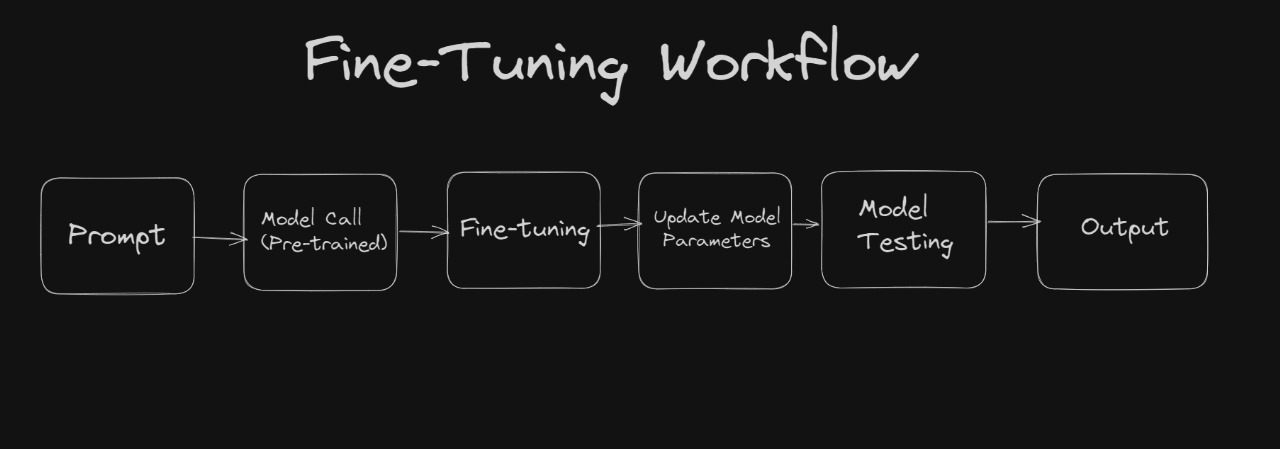

# Step 4.1: Loading the dataset

*We have taken the [Question_Answer_Python_LoRA(finetuning)](https://www.kaggle.com/datasets/ashish32700/question-answer-python-lorafinetuning) available on kaggle for fine-tuning our model.<br>Here, we are firstly reading the dataset into our variable `dataset` and then converting it into the required format for further training.*
















In [26]:
dataset=pd.read_csv(r"/kaggle/input/question-answer-python-lorafinetuning/custom_dataset_finetuning.csv")
dataset.head()

,qa
0,Instruction: What is the difference between a ...
1,Instruction: What is the difference between a ...
2,Instruction: What is the difference between th...
3,Instruction: What is the difference between an...
4,Instruction: What is the difference between `T...


In [27]:
# Converting the dataset into the required format
train_dataset = Dataset.from_pandas(dataset)

# freeing up space
del dataset

## Step 4.2: Specifying different training parameters and variables

In [28]:
# Original Model Name
model_name = "google/gemma-2b"

# Fine-tuned Model Name
new_model = "gemma-ft"

### 1. LoRA parameters
*LoRA parameters specify attention dimension, alpha scaling, and dropout probability.*

In [29]:
# LoRA attention dimension
lora_r = 4

# Alpha parameter for LoRA scaling
lora_alpha = 16

# Dropout probability for LoRA layers
lora_dropout = 0.1

### 2. bitsandbytes parameters
*BitsAndBytes parameters configure 4-bit precision base model loading and quantization settings.*

In [30]:
# Activate 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False

### 3. TrainingArguments parameters
*TrainingArguments parameters set up training configurations such as output directory, epochs, batch size, learning rate, etc.*

In [31]:
# Output directory where the model predictions and checkpoints will be stored
output_dir = "./results"

# Number of training epochs
num_train_epochs = 1

# Enable fp16/bf16 training (set bf16 to True with an A100)
fp16 = False
bf16 = False

# Batch size per GPU for training
per_device_train_batch_size = 4

# Batch size per GPU for evaluation
per_device_eval_batch_size = 4

# Number of update steps to accumulate the gradients for
gradient_accumulation_steps = 1

# Enable gradient checkpointing
gradient_checkpointing = True

# Maximum gradient normal (gradient clipping)
max_grad_norm = 0.3

# Initial learning rate (AdamW optimizer)
learning_rate = 2e-4

# Weight decay to apply to all layers except bias/LayerNorm weights
weight_decay = 0.001

# Optimizer to use
optim = "paged_adamw_32bit"

# Learning rate schedule (constant a bit better than cosine)
lr_scheduler_type = "constant"

# Number of training steps (overrides num_train_epochs)
max_steps = -1

# Ratio of steps for a linear warmup (from 0 to learning rate)
warmup_ratio = 0.03

# Group sequences into batches with same length as it saves memory and speeds up training considerably
group_by_length = True

# Save checkpoint every X updates steps
save_steps = 25

# Log every X updates steps
logging_steps = 25

### 4. SFT parameters
*SFT parameters define settings for Self-Training Framework like maximum sequence length, packing, and device mapping.*

In [32]:
# Maximum sequence length to use
max_seq_length = 256

# Pack multiple short examples in the same input sequence to increase efficiency
packing = True 

# Load the entire model on the GPU 0
device_map = {"": 0}


## Step 4.3: Define QLoRA configuration using BitsandBytesConfig

- Activate 4-bit precision loading with specified quantization type (nf4) and compute data type (float16).
- Optionally enables double quantization if specified.

In [33]:
# Load QLoRA configuration
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,                        # Activates 4-bit precision loading
    bnb_4bit_quant_type=bnb_4bit_quant_type,      # nf4
    bnb_4bit_compute_dtype=compute_dtype,         # float16
    bnb_4bit_use_double_quant=use_nested_quant,   # False
)

In [34]:
# Check GPU compatibility with bfloat16
if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("Setting BF16 to True")
        bf16 = True
    else:
        bf16 = False


## Step 4.4: Load the base model for fine-tuning

In [35]:
# Load pre-trained Gemma base model for causal language modeling using AutoModelForCausalLM and configure quantization settings with the specified BitsAndBytesConfig.
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    token=hugging_face_api_token,
    quantization_config=bnb_config,
    device_map=device_map
)

# Disable caching and set pretraining temperature.
model.config.use_cache = False
model.config.pretraining_tp = 1

# Load tokenizer for the model with specified settings.
tokenizer = AutoTokenizer.from_pretrained(model_name,
                                          token=hugging_face_api_token,
                                          trust_remote_code=True)

# Set padding token and side to fix overflow issue with fp16 training.
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right" # This will fix weird overflow issue with fp16 training

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## Step 4.5: Define LoRA configuration using LoraConfig



*Specify parameters such as alpha scaling, dropout probability, attention dimension (r), bias type, task type, and target modules. Target modules indicate which layers of the model will be modified to incorporate LoRA.*

In [36]:
# Load LoRA configuration
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj","gate_proj", "up_proj"]
)

## Step 4.6: Define training parameters using TrainingArguments








In [37]:
# Set up training parameters using TrainingArguments from the transformers library.
training_arguments = TrainingArguments(
    output_dir=output_dir,  # Directory to store model checkpoints and predictions.
    num_train_epochs=num_train_epochs,  # Number of training epochs.
    per_device_train_batch_size=per_device_train_batch_size,  # Batch size per GPU for training.
    gradient_accumulation_steps=gradient_accumulation_steps,  # Number of steps to accumulate gradients before updating weights.
    optim=optim,  # Optimizer to use for training.
    save_steps=save_steps,  # Interval to save model checkpoints.
    logging_steps=logging_steps,  # Interval to log training progress.
    learning_rate=learning_rate,  # Initial learning rate for the optimizer.
    weight_decay=weight_decay,  # Weight decay to apply to model parameters.
    fp16=fp16,  # Whether to use mixed precision training with FP16.
    bf16=bf16,  # Whether to use mixed precision training with BF16.
    max_grad_norm=max_grad_norm,  # Maximum gradient norm for gradient clipping.
    max_steps=max_steps,  # Maximum number of training steps.
    warmup_ratio=warmup_ratio,  # Ratio of warmup steps to total training steps.
    group_by_length=group_by_length,  # Group sequences into batches with similar lengths.
    lr_scheduler_type=lr_scheduler_type,  # Type of learning rate scheduler to use.
    report_to="tensorboard",  # Destination for reporting training progress.
)


training_arguments  # Display the configured training arguments.

TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=False,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=None,
eval_strategy=no,
evaluation_strategy=None,
fp16=False,
fp16_backend=auto,
fp16

## Step 4.7: Creating formatting function (Optional)

*The formatting_prompts_func takes the entire dataset as an input, iterates through the rows and creates a formatted text containing query and corresponding code from the dataset. It returns a list of all the formatted texts. The code block is not required in our case since the dataset is already formatted.*

In [38]:
# def formatting_prompts_func(example):
#   output_texts = []
#   for i in range(len(example['qa'])):
# #     text = f"Query:\n{example['Question']}\n\nAnswer:\n{example['Answer']}"
#     text = example['qa']
#     output_texts.append(text)
#   return output_texts

## Step 4.8: Creating a trainer instance for fine-tuning Gemma Base model

In [39]:
# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,  # Pre-trained model to be fine-tuned.
    train_dataset=train_dataset,  # Training dataset.
    peft_config=peft_config,  # LoRA configuration for fine-tuning.
#     formatting_func=formatting_prompts_func,  # Function to format prompts for training. (Optional)
    max_seq_length=max_seq_length,  # Maximum sequence length for tokenization.
    tokenizer=tokenizer,  # Tokenizer for tokenizing inputs.
    args=training_arguments,  # Training arguments defining training settings.
    dataset_text_field="qa"  # This field is used when the dataset is already formatted to provide the column which is to be used for training
)

# "dataset_text_field" is not required while using formatting function argument

Map:   0%|          | 0/419 [00:00<?, ? examples/s]

## Step 4.9: Train the Model

*Train the Base model and save it as gemma-ft*

In [40]:
# Train model
trainer.train()
trainer.model.save_pretrained(new_model)

Step,Training Loss
25,1.118000
50,0.880100
75,0.871000
100,0.805600


*We have successfully trained our Model!*

# Let's Test our Fine-tuned Model



*Here, we are merging the existing weights of our model with the updated weights after fine-tuning.*

- Initialize a pre-trained base model for causal language modeling using `AutoModelForCausalLM`.
- Specifies configurations such as low CPU memory usage, returning outputs as dictionaries, using torch float16 data type, and mapping devices.
- Fine-tunes the base model with `PeftModel`, incorporating a new model name.
- Merges weights and unloads unnecessary modules from the fine-tuned model.
- Reloads the tokenizer from the pre-trained model.
- Configures the tokenizer to pad sequences with end-of-sequence tokens on the right side to address an overflow issue.
- Sets up a fine-tuning pipeline for a language model while optimizing memory usage and ensuring proper tokenization.

In [41]:
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map=device_map,
)
model = PeftModel.from_pretrained(base_model, new_model)
model = model.merge_and_unload()

# Reload tokenizer to save it
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

*We need to provide a sample input to the model, tokenize it, convert it to PyTorch tensors, and move them to GPU so as to check the working of our fine-tuned model.*

## Output Parser

In [42]:
def output_parser(text):
    # Define the regular expression to find the first "Answer:"
    pattern = r'Response:(.*?)(Query:|$)'
    
    # Search for the pattern in the text
    match = re.search(pattern, text, re.DOTALL)
    
    if match:
        # Extract the first answer and strip leading/trailing whitespace
        first_answer = match.group(1).strip()
        return first_answer
    else:
        return None

In [43]:
input_text = "Instruction: How do you split a string into a list using Python?\nResponse:\n"
input_ids = tokenizer(input_text, return_tensors="pt").to("cuda")
# print(input_ids)
outputs = model.generate(**input_ids, max_length=150)
response = tokenizer.decode(outputs[0])
# print(output_parser(response))

In [44]:
response[5:]

'Instruction: How do you split a string into a list using Python?\nResponse:\n"Sure. Here\'s how to split a string into a list using Python:", \'```python\', \'string = "Hello world!"\', \'list = string.split()\', \'print(list)\', \'```\', \'**Output:**\', \'```\', \'["Hello", "world"]\', \'```\', \'**Explanation:**\', \'* `string` is the string we want to split.\', \'* `split()` is a built-in function that takes a string and a separator as arguments. It returns a list of strings where each string is a substring of the original string that is separated by the separator.\', \'* `string.split()` takes the string "'

In [45]:
print(response[5:])

Instruction: How do you split a string into a list using Python?
Response:
"Sure. Here's how to split a string into a list using Python:", '```python', 'string = "Hello world!"', 'list = string.split()', 'print(list)', '```', '**Output:**', '```', '["Hello", "world"]', '```', '**Explanation:**', '* `string` is the string we want to split.', '* `split()` is a built-in function that takes a string and a separator as arguments. It returns a list of strings where each string is a substring of the original string that is separated by the separator.', '* `string.split()` takes the string "


In [46]:
from IPython.display import Markdown, display
display(Markdown(response))

<bos>Instruction: How do you split a string into a list using Python?
Response:
"Sure. Here's how to split a string into a list using Python:", '```python', 'string = "Hello world!"', 'list = string.split()', 'print(list)', '```', '**Output:**', '```', '["Hello", "world"]', '```', '**Explanation:**', '* `string` is the string we want to split.', '* `split()` is a built-in function that takes a string and a separator as arguments. It returns a list of strings where each string is a substring of the original string that is separated by the separator.', '* `string.split()` takes the string "

# Comparing with other 2B parameter models

*We will determine which, among the set of pre-trained text-generation models, has the best performance based on different evaluation metrics.<br>For this, we will use the method of TOPSIS - **T**echnique for **O**rder of **P**reference by **S**imilarity to **I**deal **S**olution*

*TOPSIS is an ideal method for dealing with Multiple Criteria Decision Making(MCDM) problems.*

*To check whether our fine-tuning methodology holds for different cases, we have taken 4 models in total for comparison:*
+ **Open Source**
    - [GreenBitAI/LLaMA-2-1.1B-2bit-groupsize32](https://huggingface.co/GreenBitAI/LLaMA-2-1.1B-2bit-groupsize32)
    - [microsoft/rho-math-1b-v0.1](https://huggingface.co/microsoft/rho-math-1b-v0.1)
+ **Base Gemma-2B**
    - [google/gemma-2b](https://huggingface.co/google/gemma-2b)
+ **Fine-tuned Gemma-ft**
    - gemma-ft
    
    
*We'll be testing all these models for different sample prompts and comparing the obtained results of different evaluation metrics:*

+ **Precision:** *Precision measures the accuracy of positive predictions made by the model. It is calculated as the ratio of true positive predictions to the total number of positive predictions (both true positives and false positives). In other words, precision tells us how many of the predicted positive instances are actually positive.*

+ **Recall:** *Recall measures the ability of the model to correctly identify all relevant instances. It is calculated as the ratio of true positive predictions to the total number of actual positive instances (both true positives and false negatives). In other words, recall tells us how many of the actual positive instances were identified correctly by the model.*

+ **F1 Score:** *F1 score is the harmonic mean of precision and recall. It provides a single metric that balances both precision and recall. F1 score is calculated as 2 * (precision * recall) / (precision + recall). It ranges from 0 to 1, where a higher value indicates better performance. F1 score is especially useful when the class distribution is uneven or when false positives and false negatives have different costs.*

+ **BLEU Score:** *BLEU score measures how similar a generated text is to one or more reference texts by counting overlapping word sequences. It ranges from 0 to 1, with higher scores indicating greater similarity.*

In [47]:
llm1 = HuggingFaceHub(huggingfacehub_api_token=hugging_face_api_token,
                     repo_id = "GreenBitAI/LLaMA-2-1.1B-2bit-groupsize32",
                     model_kwargs = {"temperature" : 0.7,"max_length": 150}
)
llm2 = HuggingFaceHub(huggingfacehub_api_token=hugging_face_api_token,
                     repo_id = "microsoft/rho-math-1b-v0.1",
                     model_kwargs = {"temperature" : 0.7,"max_length": 150}
)
llm3 = HuggingFaceHub(huggingfacehub_api_token=hugging_face_api_token,
                     repo_id = "google/gemma-2b",
                     model_kwargs = {"temperature" : 0.7,"max_length": 150}
)


llm=[llm1,llm2,llm3,model]

/opt/conda/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `HuggingFaceHub` was deprecated in LangChain 0.0.21 and will be removed in 0.3.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEndpoint`.
  warn_deprecated(


This is the sample dataset we have taken for evaluation

In [48]:
evaluation_dataset = [
  {
    "prompt": "What is a function in Python?",
    "target": "In Python, a function is a block of reusable code that performs a specific task. It allows you to organize your code into logical units and reuse it throughout your program."
  },
  {
    "prompt": "What is a for loop in Python?",
    "target": "A for loop in Python is used to iterate over a sequence (such as a list, tuple, or string) and execute a block of code for each item in the sequence. It simplifies repetitive tasks and makes code more concise."
  }
]


*Here, we have created a resulting dataframe called "df" to store the differnt scores obtained after generating the text. Using nested loops, we iterate through each prompt in the evaluation dataset and each language model in the list. For each prompt-model combination, it generates text based on the prompt using the corresponding language model and the different metric scores are calculated. These are then stored in the dataframe "score_df" for further use.*


In [49]:
score_df = pd.DataFrame(columns=["Prompt","Model", "Precision", "Recall", "F1_Score", "Bleu_Score"])
bertscore_metric = load_metric('bertscore', trust_remote_code=True)
j=0
i=0
for e in evaluation_dataset:
    for l,model in enumerate(llm,start=1):  
        prompt = e["prompt"]        
        expected_output = e["target"]
        if l==4:
            input_text = f"Instruction:\n{prompt}\nResponse:"
            input_ids = tokenizer(input_text, return_tensors="pt").to("cuda")
            outputs = model.generate(**input_ids, max_length=150)
            response = tokenizer.decode(outputs[0])
            generated_text = response[5:]
        else:
            generated_text = model(prompt)
        bleu_score = sentence_bleu([expected_output.split()], generated_text.split(), smoothing_function=SmoothingFunction().method1)
        bert_scores = bertscore_metric.compute(predictions=[generated_text], references=[expected_output], lang="en")
        precision = bert_scores['precision'][0]
        recall = bert_scores['recall'][0]
        f1 = bert_scores['f1'][0]
        score_df.loc[j] = ["Prompt {}".format(i+1),"LLM {}".format(l), precision, recall, f1, bleu_score]
        j+=1
    i+=1

/tmp/ipykernel_24/2591881035.py:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  bertscore_metric = load_metric('bertscore', trust_remote_code=True)


/opt/conda/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `BaseLLM.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [50]:
# Saving the file into scores.csv
score_df.to_csv("scores.csv", index=False)

In [51]:
score_df #display

,Prompt,Model,Precision,Recall,F1_Score,Bleu_Score
0,Prompt 1,LLM 1,0.711849,0.817776,0.761145,0.013948
1,Prompt 1,LLM 2,0.828711,0.869009,0.848382,0.020163
2,Prompt 1,LLM 3,0.849128,0.884466,0.866437,0.066688
3,Prompt 1,LLM 4,0.827373,0.877315,0.851612,0.072889
4,Prompt 2,LLM 1,0.702998,0.810879,0.753094,0.024701
5,Prompt 2,LLM 2,0.837026,0.872124,0.854214,0.105904
6,Prompt 2,LLM 3,0.799594,0.831289,0.815133,0.013458
7,Prompt 2,LLM 4,0.783213,0.870262,0.824446,0.081580


## TOPSIS functions

In [52]:
# Function for Weighted Normalization of the input dataframe
def wt_norm(df,weights):
  df = df.div(df.apply(lambda x: x*2).apply(sum).apply(lambda x: x*0.5))
  df = df.mul(weights)
  return df

In [53]:
def topsis(input,weights, impacts):
    # Drop unnecessary columns from input DataFrame.
    df = input.drop(['Prompt','Model'],axis=1)
    
    # Normalize the DataFrame using weights.
    df = wt_norm(df,weights)
    
    # Initialize lists to store best and worst values for each column based on impacts.
    b=[]
    w=[]
    
    # Determine best and worst values for each column based on impacts.
    for i in range(len(impacts)):
        if impacts[i]=='+':
            b.append(max(df.iloc[:,i]))
            w.append(min(df.iloc[:,i]))
        else:
            b.append(min(df.iloc[:,i]))
            w.append(max(df.iloc[:,i]))

    # Calculate performance scores.
    s_best=[]
    s_worst=[]
    for index, row in df.iterrows():
        s_best.append((sum((row - b) ** 2) ** 0.5) * 0.5)
        s_worst.append((sum((row - w) ** 2) ** 0.5) * 0.5)
    s_total = [i + j for i, j in zip(s_worst, s_best)]
    performance = [i / j if j != 0 else 0 for i, j in zip(s_worst, s_total)]
    df['Topsis Score'] = performance
    
    # Rank the Models based on their Topsis Score.
    sorted_array = df.loc[:,'Topsis Score'].argsort()
    ranks = np.empty_like(sorted_array)
    ranks[sorted_array] = np.arange(len(sorted_array))
    n=len(sorted_array)
    ranks = [n-i for i in ranks]
    df.loc[:,'Rank'] = ranks
    
    return df

In [54]:
# Initializing inputs, weights and impacts that need to be used for TOPSIS
inputs = [score_df[0:4], score_df[4:8], score_df[8:12], score_df[12:16]]
weights = [1, 1, 1, 1]
impacts = ["+", "+", "+", "+"]

In [55]:
# Perform TOPSIS for the three prompts and print their results
for i in range(2):
    print("Prompt ",i+1,":",evaluation_dataset[i]['prompt'])
    res = topsis(inputs[i], weights, impacts)
    
    print(res)
    print("\n")

Prompt  1 : What is a function in Python?
   Precision    Recall  F1_Score  Bleu_Score  Topsis Score  Rank
0   0.221273  0.237135  0.228739    0.080307      0.000000     4
1   0.257599  0.251992  0.254955    0.116089      0.163189     3
2   0.263945  0.256474  0.260381    0.383951      0.896385     2
3   0.257183  0.254400  0.255926    0.419653      0.976193     1


Prompt  2 : What is a for loop in Python?
   Precision    Recall  F1_Score  Bleu_Score  Topsis Score  Rank
4   0.225116  0.239582  0.231943    0.109468      0.120338     3
5   0.268034  0.257678  0.263087    0.469342      1.000000     1
6   0.256048  0.245612  0.251051    0.059644      0.082433     4
7   0.250802  0.257128  0.253919    0.361545      0.735284     2




# Inference
*We can clearly see from the outputs, displayed in the previous code block, that Gemma, fine-tuned for answering common python programming questions, has the overall best performance.*






## Conclusion
*From the above code results, we can conclude the following:*
+ Few-Shot Prompting, although accurate, requires example cases tailored around the question domain.
+ Fine-tuning increases accuracy, provides multiple result sets for the same input, and has an overall better performance when compared to the base model and other open source models.